In [1]:
# setting up the notebook width to 100% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. import libraries

In [2]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint

## 2. load data

In [3]:
df = pd.read_csv("./PS_20174392719_1491204439457_log.csv")

## 3. data cleaning

In [4]:
df.shape

(6362620, 11)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 3.1 check data types consistency

In [6]:
df.dtypes.value_counts()

float64    5
int64      3
object     3
dtype: int64

In [7]:
df.select_dtypes(['object']).columns.tolist()

['type', 'nameOrig', 'nameDest']

In [8]:
df[["type", "nameOrig", "nameDest"]].applymap(type).value_counts()

type           nameOrig       nameDest     
<class 'str'>  <class 'str'>  <class 'str'>    6362620
dtype: int64

### 3.2 check null values and column types¶ 

In [9]:
df.info(show_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#### 3.2.1 confirm that there are no null values

In [10]:
df.isnull().any(axis=0)

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

### 3.3 check for duplicates

In [11]:
print(f"{len(df[df.duplicated()])} entries are duplicates")

0 entries are duplicates


## 4. data analysis and feature extraction

### 4.1 univariate and bivariate analysis of original data

#### 4.1.1 univariate analysis

In [12]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

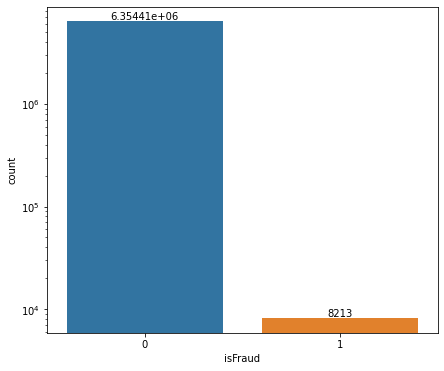

In [13]:
plt.figure(figsize=(7,6))
ax=sns.countplot(data=df, x='isFraud');
ax.bar_label(ax.containers[0])
ax.set_yscale('log')

In [14]:
df.isFraud.value_counts(normalize=1) * 100.

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

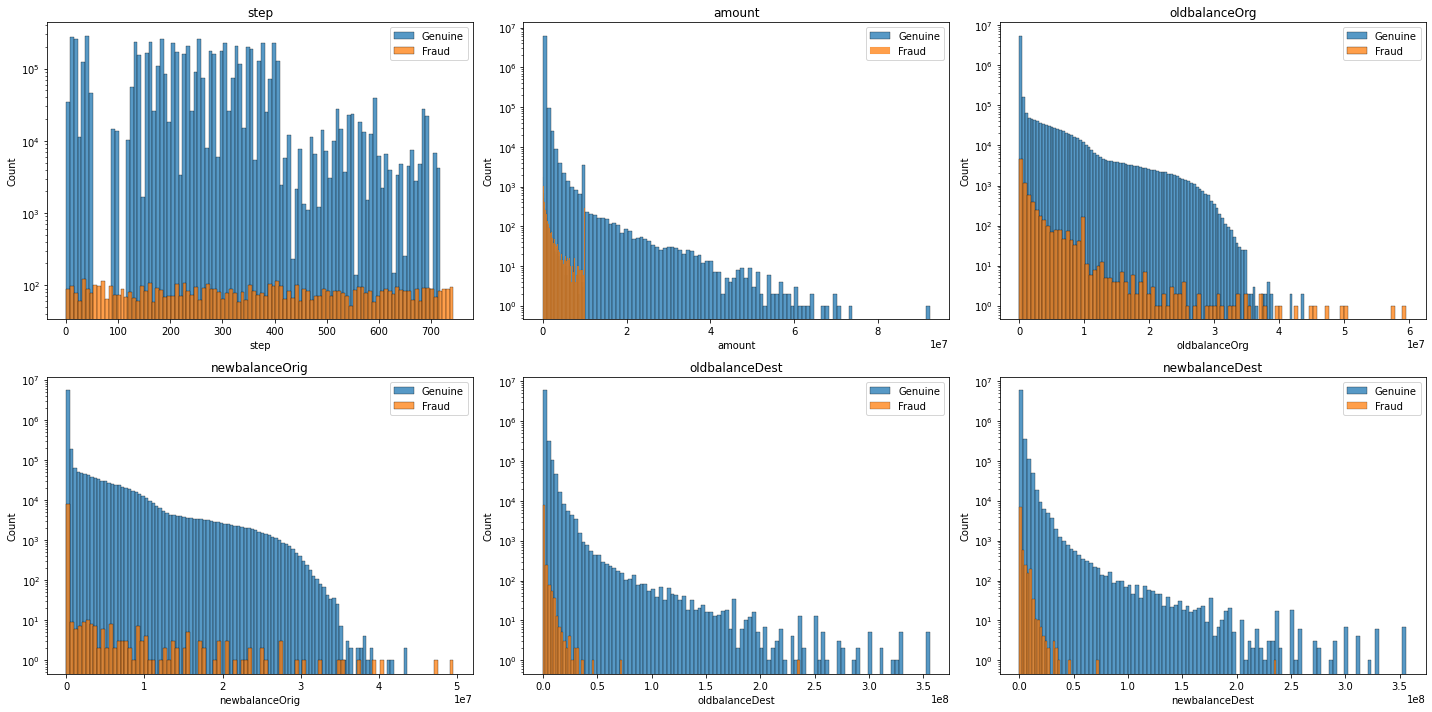

In [15]:
def plot_numerical_features(features):    
    fig, ax = plt.subplots(2, len(features)//2, figsize=(20, 10))
    i = 0
    for feature in features:
        i += 1
        plt.subplot(2, len(features)//2, i)
        sns.histplot(df[df['isFraud']==0][feature], bins=100, label="Genuine")
        sns.histplot(df[df['isFraud']==1][feature], bins=100, label="Fraud")
        plt.title(feature)
        plt.yscale('log')
        plt.legend()
    fig.tight_layout() 
    plt.show()

plot_numerical_features(df.select_dtypes(["int", "float"]).columns[:-2])

In [16]:
len(df["nameOrig"].unique()), len(df["nameDest"].unique())

(6353307, 2722362)

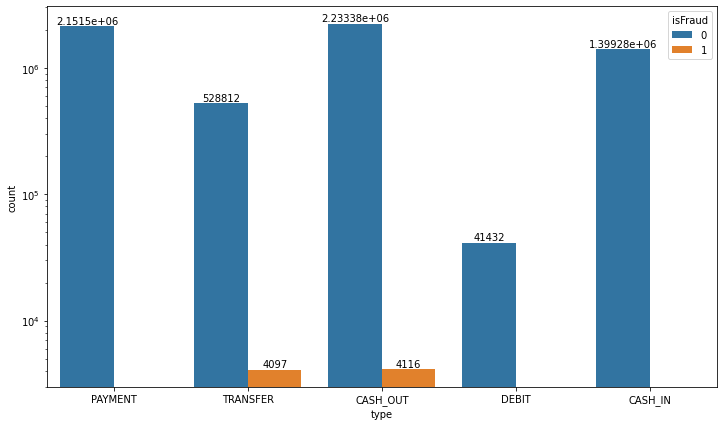

In [17]:
def bivariate_countplot(feature, target='isFraud'):
    fig=plt.figure(figsize=(12, 7))
    ax=sns.countplot(data=df, x=feature, hue=target);
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_yscale('log')
bivariate_countplot('type')

### 4.3 feature extraction

#### 4.3.1 encode string features into numbers

In [18]:
pd.get_dummies(df["type"]).astype(int).head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [19]:
df = pd.concat([df, pd.get_dummies(df["type"]).astype(int)], axis=1)

In [20]:
columns_to_select = sorted(["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"])

In [21]:
min(df.step.diff().dropna())

0.0

## 5. model training and evaluation


### 5.1 train test split

#### 5.1.1 check if the dataset is sorted in increasing order of time

#### 5.1.2 split dataset in time-series manner

In [22]:
split_index = int(len(df) * 0.8)
X, y = df[columns_to_select], df['isFraud']
X_train, X_test, y_train, y_test = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]

#### 5.1.3 ensure both train and test sets have similar fraud percentages

In [23]:
y_train.mean(), y_test.mean()

(0.0007777849376514706, 0.0033429624902948786)

### 5.2 training decision tree model using random hyperparameter search with time-series splits-based k-fold cross validation

In [24]:
# Create a Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

param_dist = {'max_depth': randint(1, 5), 
                  'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10}]}

def train_model(model, param_dist):
    start = time.time()

    # Define the time series cross-validation strategy 
    tscv = TimeSeriesSplit(n_splits=3) 

    # Run randomized search
    rand_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=3, cv=tscv, random_state=42, scoring="average_precision")

    # Fit the randomized search to the training data
    rand_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print('Best hyperparameters:', rand_search.best_params_)

    # return the trained model
    model = rand_search.best_estimator_

    print(time.time()-start)
    
    return model

model = train_model(dt, param_dist)

Best hyperparameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': 4}
44.48578119277954


### 5.3 evaluating model performance using precision recall curve

#### 5.3.1 plot precision-recall curve

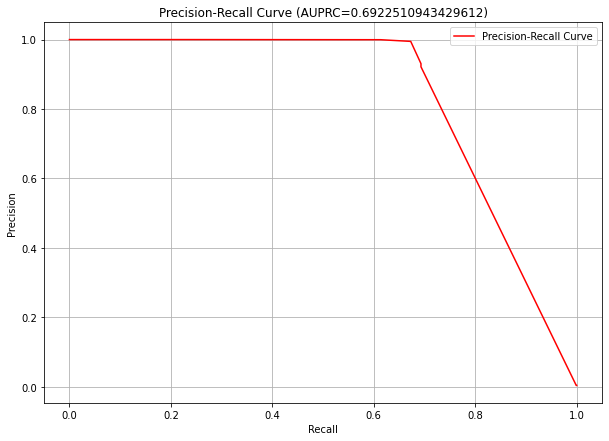

In [25]:
plt.figure(figsize=(10,7))
y_pred_prob = model.predict_proba(X_test)
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
auprc = average_precision_score(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
plt.legend()
plt.grid(True)

## 6 Model interpretability

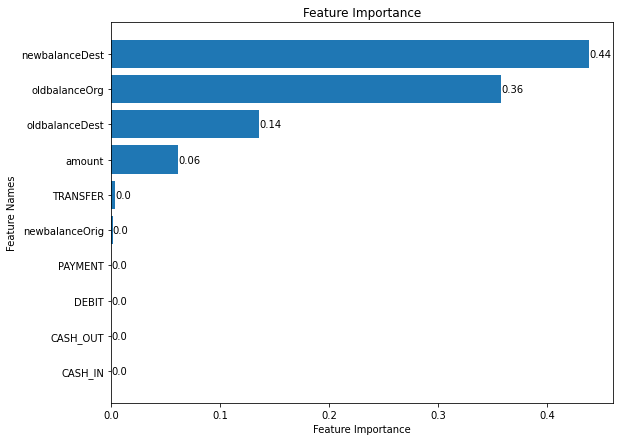

In [26]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features)

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model)

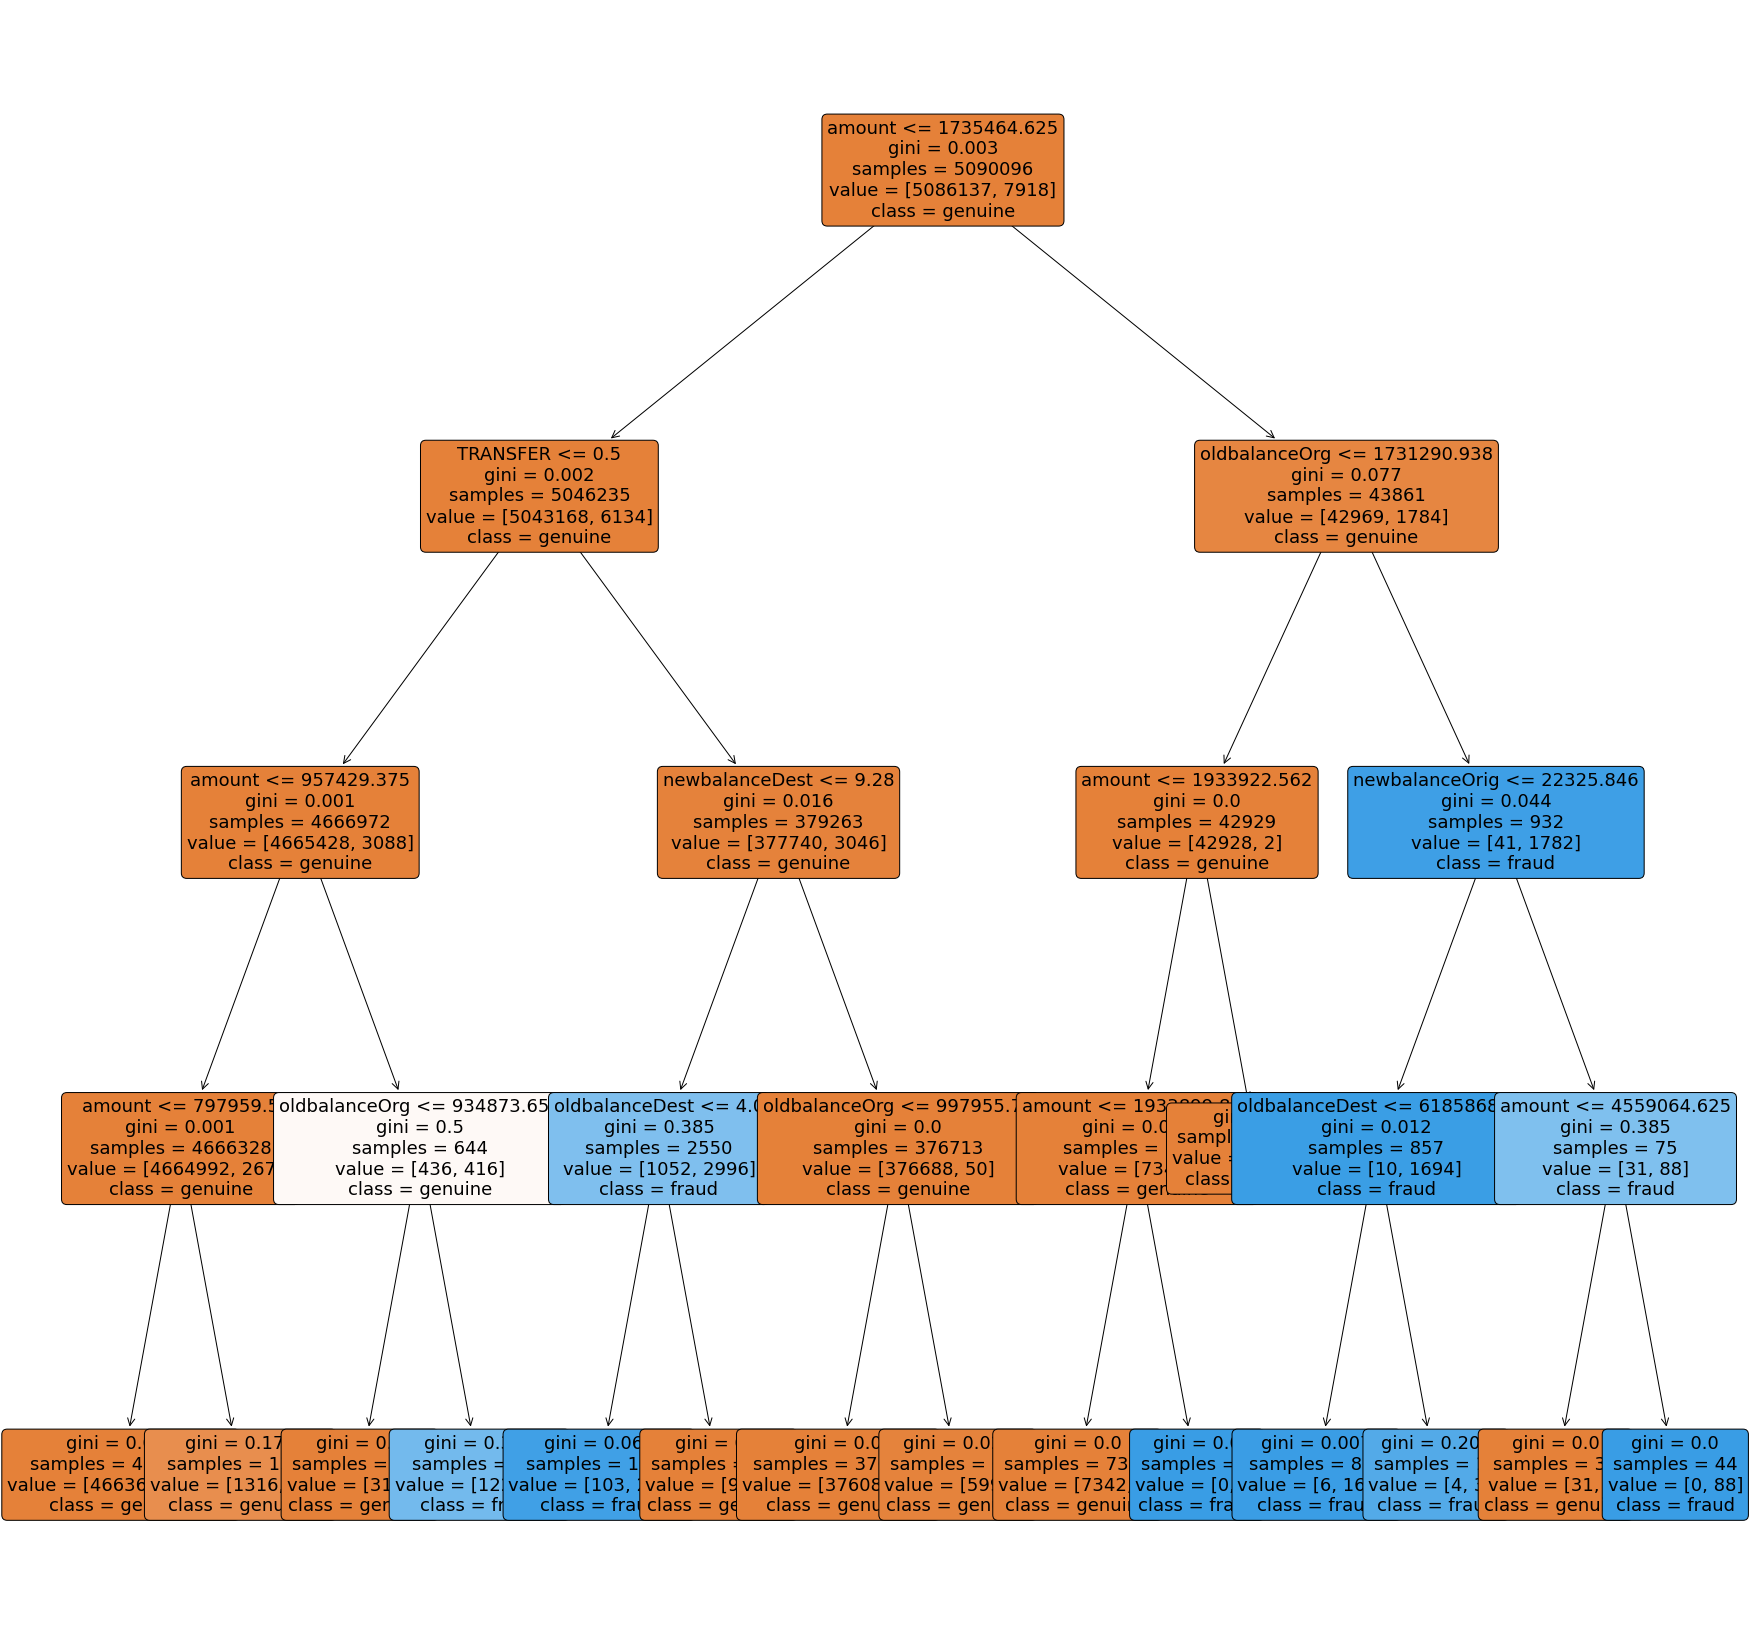

In [27]:
plt.figure(figsize=(30, 30))
tree.plot_tree(model, feature_names=model.feature_names_in_,  
                   class_names=["genuine", "fraud"],
                   filled=True, rounded=True, fontsize=18);

## 7. Replace decision tree with random forest

### 7.1 Training random forest model using random hyperparameter search with time-series splits-based k-fold cross validation

In [28]:
# Create a Decision Tree model
rf = RandomForestClassifier(random_state=42)

# Set the parameters to search over
param_dist = {'max_depth': randint(1, 5), 'n_estimators': randint(2, 10),
              'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10}]}

model_rf = train_model(rf, param_dist)

Best hyperparameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': 4, 'n_estimators': 6}
67.36221098899841


### 7.2 evaluating model performance using precision recall curve

#### 7.2.1 plot precision-recall curve

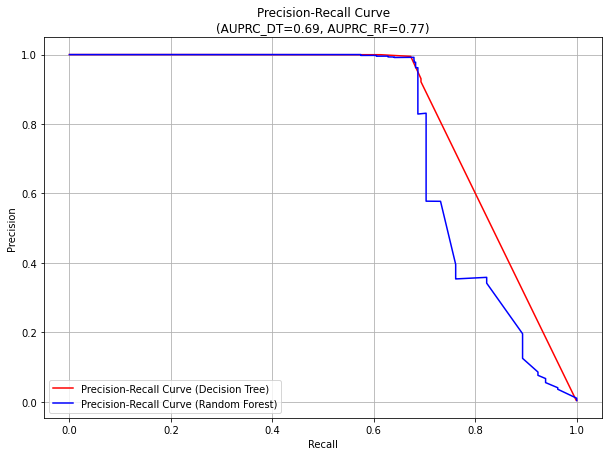

In [29]:
plt.figure(figsize=(10,7))
y_pred_prob_rf = model_rf.predict_proba(X_test)
# Compute precision and recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_prob_rf[:,1])
auprc_rf = average_precision_score(y_test, y_pred_prob_rf[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve (Decision Tree)', color='r')
plt.plot(recall_rf, precision_rf, label='Precision-Recall Curve (Random Forest)', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\n(AUPRC_DT={round(auprc, 2)}, AUPRC_RF={round(auprc_rf, 2)})')
plt.legend()
plt.grid(True)

### 7.3 Model interpretability

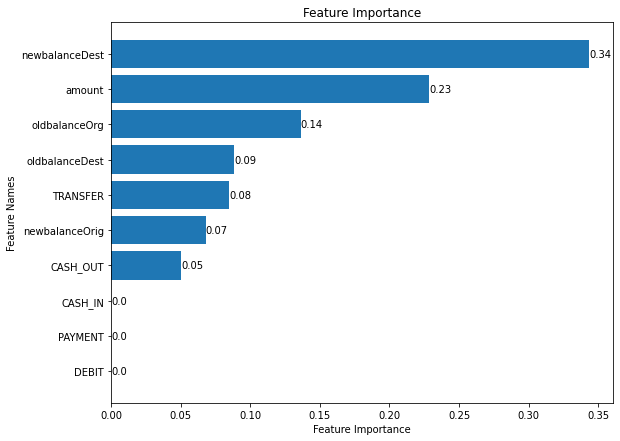

In [30]:
plot_feature_importances(model_rf)

In [31]:
len(model_rf.estimators_)

6

In [32]:
model_rf.estimators_

[DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1201263687)]

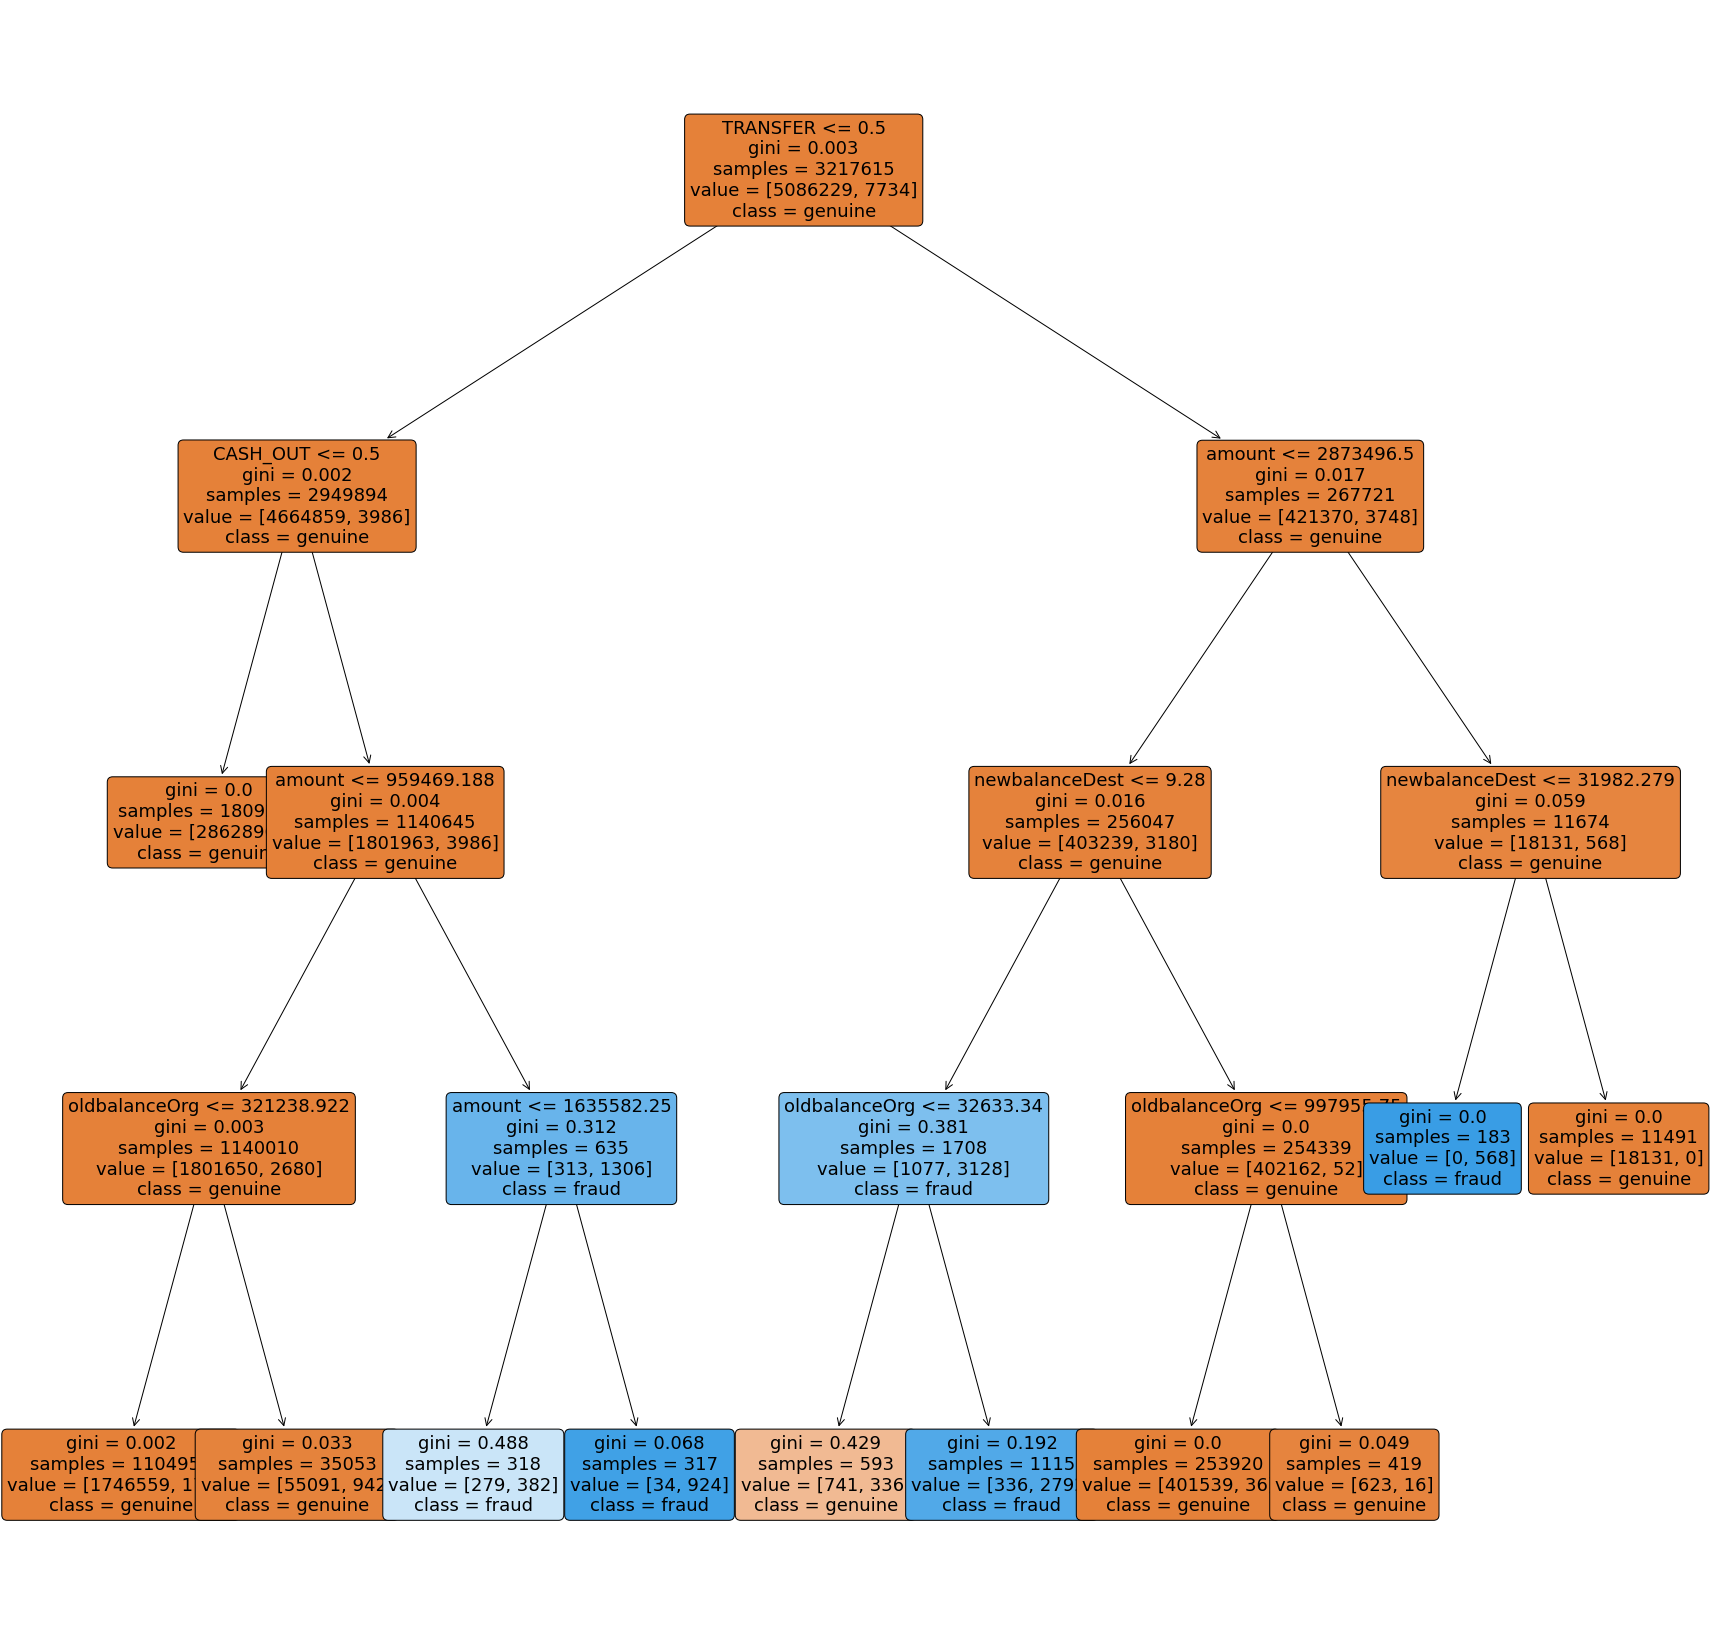

In [33]:
plt.figure(figsize=(30, 30))
tree.plot_tree(model_rf.estimators_[0], feature_names=model_rf.feature_names_in_,  
                   class_names=["genuine", "fraud"],
                   filled=True, rounded=True, fontsize=18);

## 8. feature engineering and data analysis

### 8.1 name substring features, combining namesubstring features 

In [34]:
df["nameOrig"].str[0].value_counts()

C    6362620
Name: nameOrig, dtype: int64

In [35]:
df["nameDest"].str[0].value_counts()

C    4211125
M    2151495
Name: nameDest, dtype: int64

In [36]:
df["nameOrig"].str[0:2].value_counts()

C1    3290968
C2     766936
C7     330560
C5     330009
C6     329312
C4     329176
C8     328926
C9     328795
C3     327938
Name: nameOrig, dtype: int64

benfords law ^^ vv

In [37]:
df["nameDest"].str[0:2].value_counts()

C1    2177198
M1    1113250
C2     509697
M2     258735
C7     221434
C8     218371
C9     218312
C4     216903
C3     216675
C5     216484
C6     216051
M7     111760
M9     111700
M8     111350
M5     111343
M3     111298
M4     111116
M6     110943
Name: nameDest, dtype: int64

In [38]:
df["categoryDest"] = df["nameDest"].str[0]

### 8.2 balance delta features, and orig<>dest balance comparison features

In [39]:
df["amountOrig"] = df.oldbalanceOrg - df.newbalanceOrig
df["amountDest"] = df.newbalanceDest - df.oldbalanceDest

In [40]:
(df.amount-df.amountOrig).mean()

201092.46805324164

In [41]:
(df.amount-df.amountDest).mean()

55567.17186685235

In [42]:
df["errorBalanceOrig"] = df.amount - df.amountOrig
df["errorBalanceDest"] = df.amount - df.amountDest

### 8.3 bivariate analyses using new features

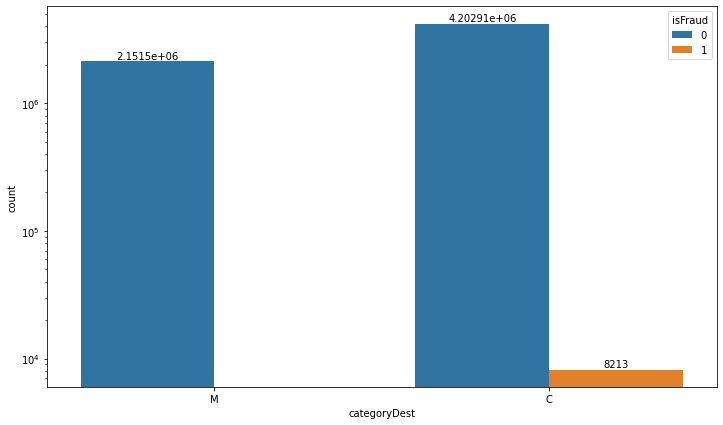

In [44]:
bivariate_countplot('categoryDest')

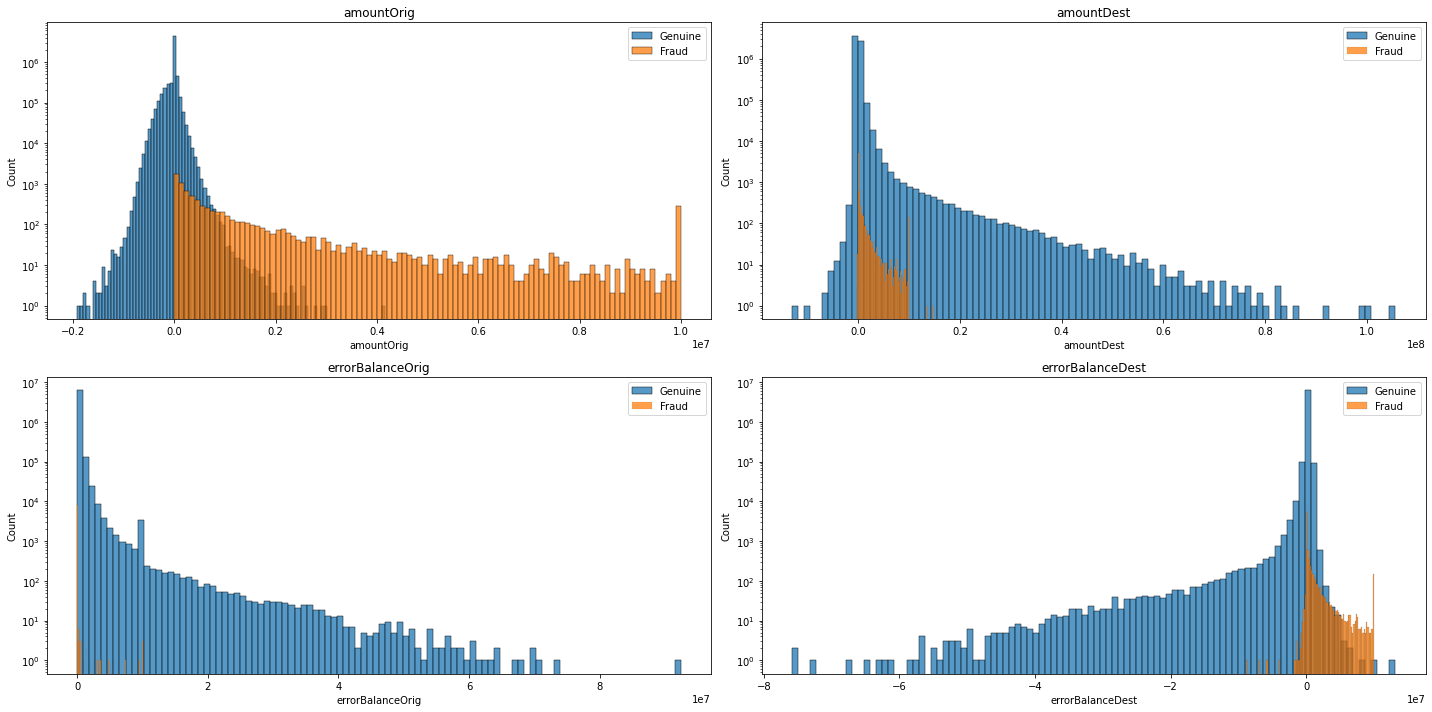

In [45]:
plot_numerical_features(["amountOrig", "amountDest", "errorBalanceOrig", "errorBalanceDest"])

#### 8.3.1 one-hot encode categoryDest

In [46]:
pd.get_dummies(df["categoryDest"]).astype(int).head()

,C,M
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


In [47]:
df = pd.concat([df, pd.get_dummies(df["categoryDest"]).astype(int)], axis=1)

### 8.4 multivariate analysis

Text(0.5, 1.0, 'Correlation Matrix')

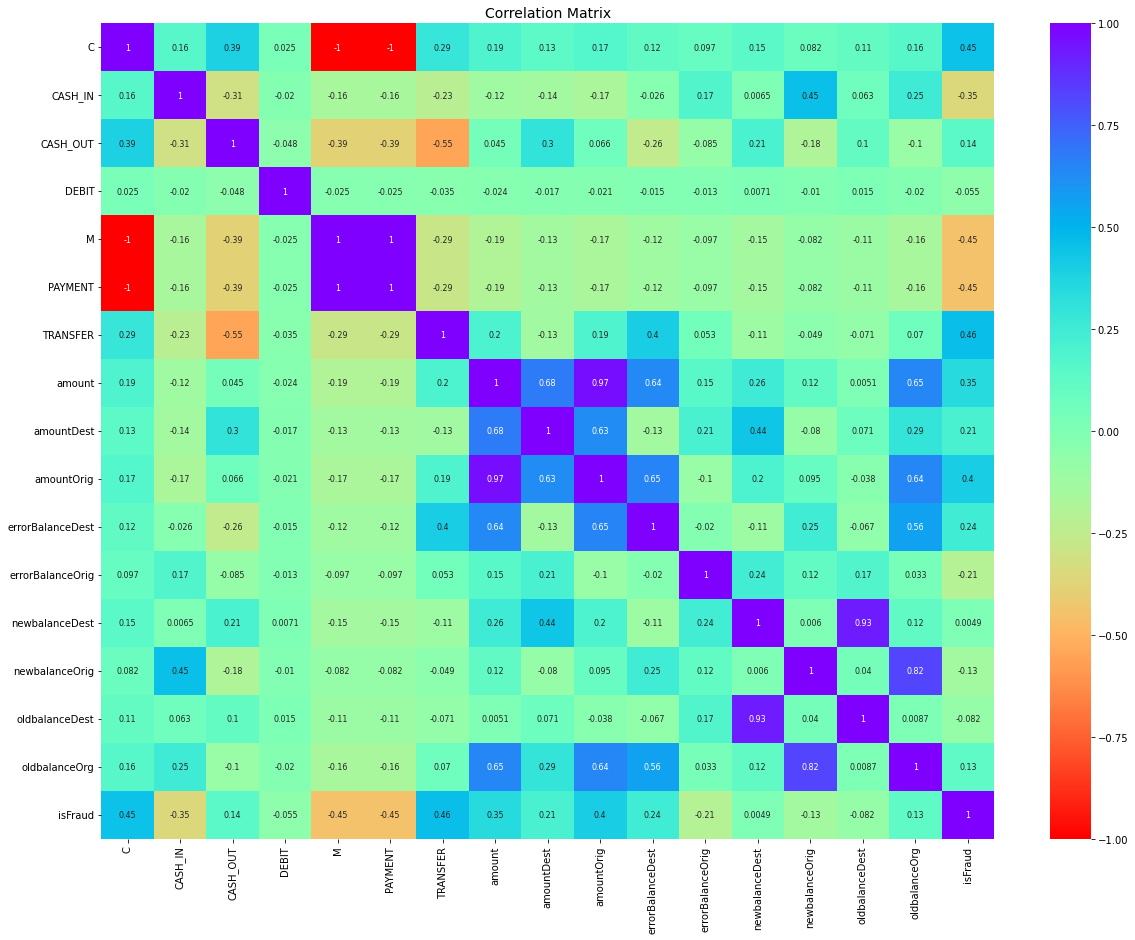

In [49]:
plt.figure(figsize=(20,15))
rus = RandomUnderSampler(random_state=42)
df_balanced = pd.concat([*rus.fit_resample(
    df[sorted(columns_to_select + ["C", "M", "amountOrig", "amountDest", "errorBalanceOrig", "errorBalanceDest"])], 
    df["isFraud"])], axis=1)
corr = df_balanced.corr()
sns.heatmap(corr, annot_kws={'size':8}, annot=True, cmap='rainbow_r')
plt.title("Correlation Matrix", fontsize=14)

In [50]:
final_columns_to_select = sorted(columns_to_select + ["amountOrig", "amountDest", "errorBalanceOrig", "errorBalanceDest"])

## 9. Final random forest model

### 9.1 train test split

#### 9.1.1 split dataset in time-series manner

In [51]:
X, y = df[final_columns_to_select], df['isFraud']
X_train, X_test, y_train, y_test = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]

### 9.2 training random forest model using random hyperparameter search with time-series splits-based k-fold cross validation

In [52]:
# Create a Decision Tree model
rf = RandomForestClassifier(random_state=42)

model_rf_best = train_model(rf, param_dist)

Best hyperparameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': 4, 'n_estimators': 6}
88.3838758468628


### 9.3 evaluating model performance using precision recall curve

#### 9.3.1 plot precision-recall curve

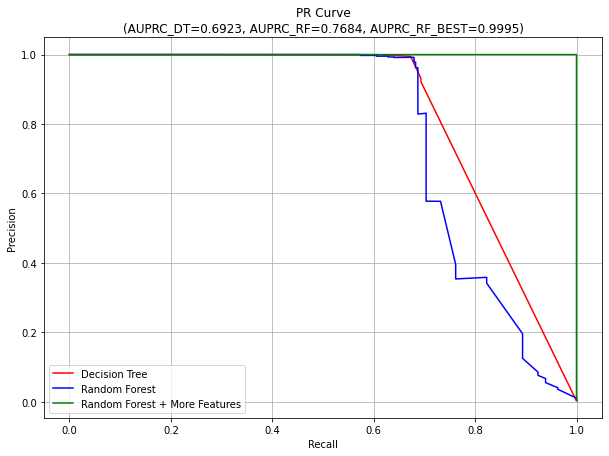

In [53]:
plt.figure(figsize=(10,7))
y_pred_prob_rf_best = model_rf_best.predict_proba(X_test)
# Compute precision and recall
precision_rf_best, recall_rf_best, thresholds_rf_best = precision_recall_curve(y_test, y_pred_prob_rf_best[:,1])
auprc_rf_best = average_precision_score(y_test, y_pred_prob_rf_best[:,1])

# Plot precision-recall curve
plt.plot(recall, precision, label='Decision Tree', color='r')
plt.plot(recall_rf, precision_rf, label='Random Forest', color='b')
plt.plot(recall_rf_best, precision_rf_best, label='Random Forest + More Features', color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curve\n(AUPRC_DT={round(auprc, 4)}, AUPRC_RF={round(auprc_rf, 4)}, AUPRC_RF_BEST={round(auprc_rf_best, 4)})')
plt.legend()
plt.grid(True)

###  9.4 Model interpretability

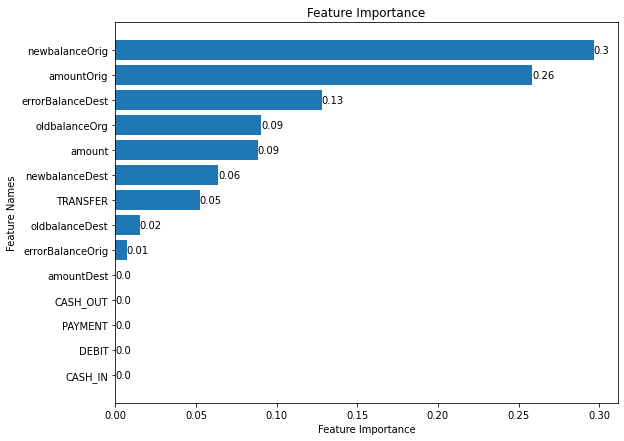

In [54]:
plot_feature_importances(model_rf_best)

In [55]:
model_rf_best.estimators_

[DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_depth=4, max_features='sqrt',
                        random_state=1201263687)]

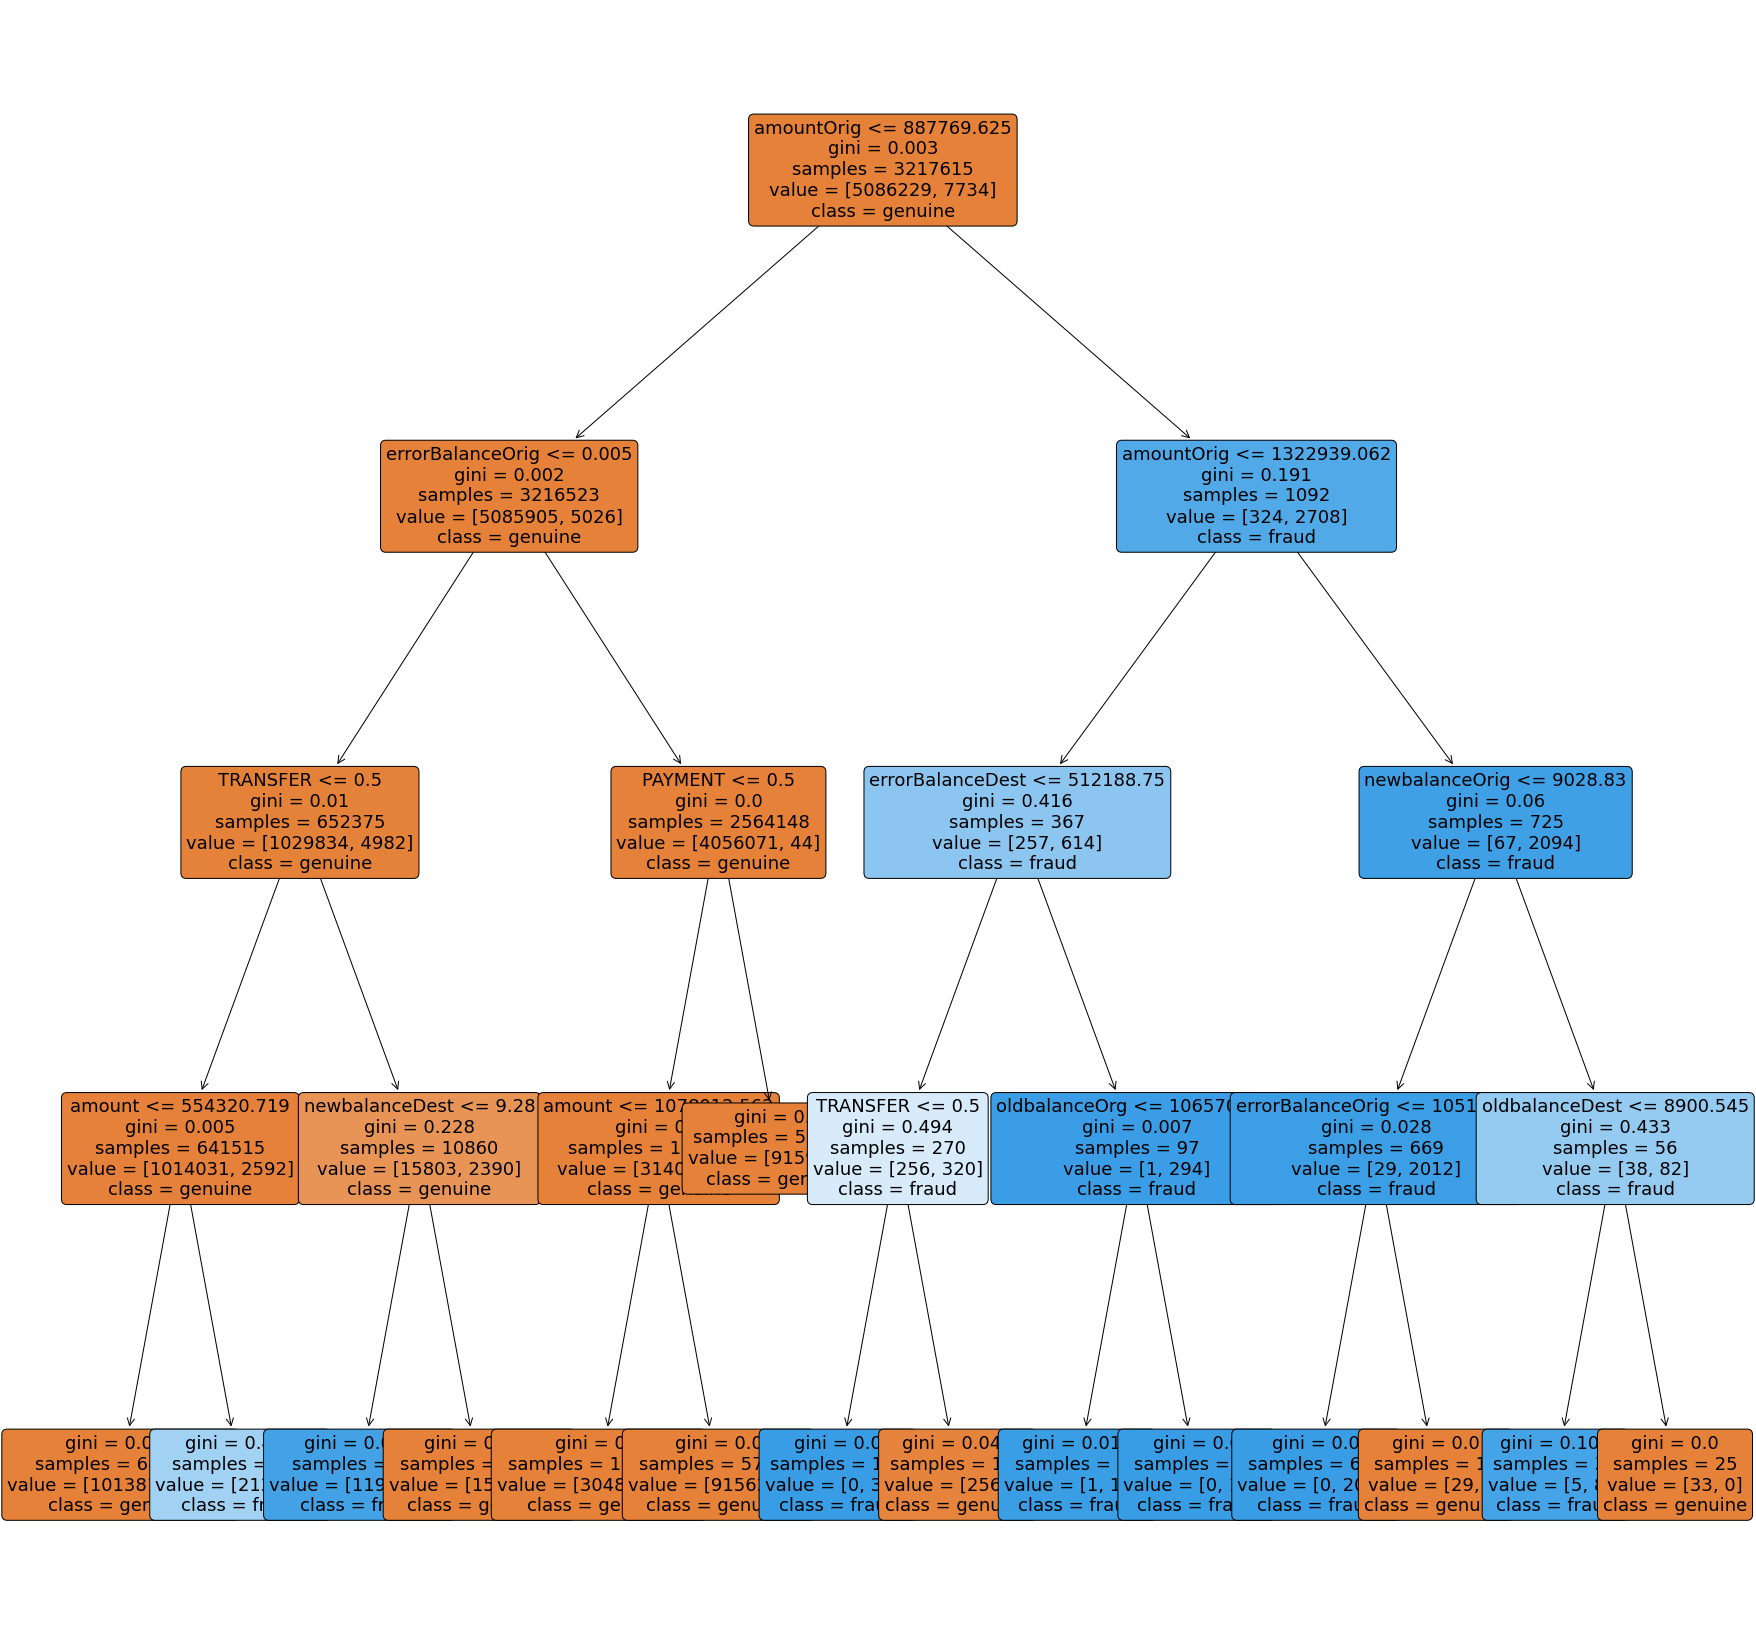

In [56]:
plt.figure(figsize=(30, 30))
tree.plot_tree(model_rf_best.estimators_[0], feature_names=model_rf_best.feature_names_in_,  
                   class_names=["genuine", "fraud"],
                   filled=True, rounded=True, fontsize=18);

### 9.5 Finding optimal model threshold

#### 9.5.1 find recall and equivalent threshold at minimum 90% precision

In [57]:
precision_needed = 0.9999
def get_optimal_threshold_index(required_precision):
    for i, p in enumerate(precision_rf_best):
        if p >= required_precision:
            break
    # in case we land on a vertical line on PR curve, we can decrease the threshold further to increase precision at the same recall
    for j, r in enumerate(recall_rf_best):
        if r < recall_rf_best[i]:
            print(f"precision={precision_rf_best[j-1]}, recall={recall_rf_best[j-1]}, at threshold={thresholds_rf_best[j-1]}")
            break
    return j-1
thres_index = get_optimal_threshold_index(precision_needed)

precision=1.0, recall=0.999529854254819, at threshold=0.31995093776824207


#### 9.5.2 visualize optimal threshold point on PR curve

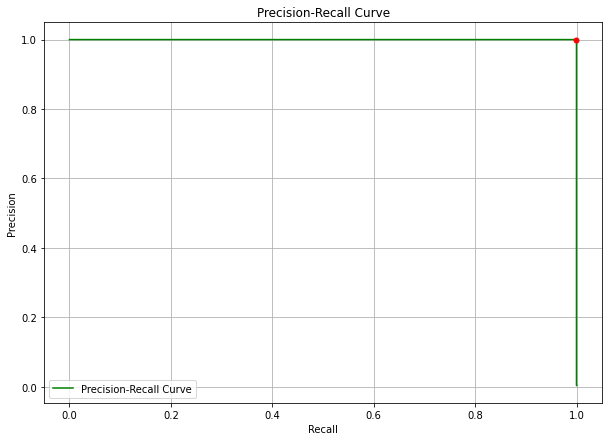

In [59]:
plt.figure(figsize=(10,7))
plt.plot(recall_rf_best, precision_rf_best, label='Precision-Recall Curve', color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.plot(recall_rf_best[thres_index], precision_rf_best[thres_index], marker='o', markersize=5, color="red");

In [61]:
threshold_rf_best = thresholds_rf_best[thres_index]

## 10. Model deployment

### 10.1 Save model

In [66]:
# Save the trained model
model_artifact = {
    "ordered_columns": final_columns_to_select,
    "rf_model": model_rf_best, 
    "rf_model_threshold": threshold_rf_best
}
joblib.dump(model_artifact, "model.joblib")

['model.joblib']

### 10.2 generate input payload from test data for model inference

In [67]:
df_payload = pd.read_csv("./PS_20174392719_1491204439457_log.csv")
df_payload.iloc[-1]

step                      743
type                 CASH_OUT
amount              850002.52
nameOrig          C1280323807
oldbalanceOrg       850002.52
newbalanceOrig            0.0
nameDest           C873221189
oldbalanceDest     6510099.11
newbalanceDest     7360101.63
isFraud                     1
isFlaggedFraud              0
Name: 6362619, dtype: object

In [68]:
json_payload = df_payload.iloc[-1][[c for c in df_payload.columns if 'Fraud' not in c]].to_dict()
json_payload

{'step': 743,
 'type': 'CASH_OUT',
 'amount': 850002.52,
 'nameOrig': 'C1280323807',
 'oldbalanceOrg': 850002.52,
 'newbalanceOrig': 0.0,
 'nameDest': 'C873221189',
 'oldbalanceDest': 6510099.11,
 'newbalanceDest': 7360101.63}

In [69]:
with open("./test_payload.json", "w") as f:
    json.dump(json_payload, f)